In [1]:
#Using 99.5 percentile for heatwaves in Reanalysis data, what is the percentage occurrence from climate model data
#PNW and Siberia
#bias correction for Siberia

pathout ="/nfs/see-fs-01_teaching/ee21pnm/Project/output"

##IMPORT PACKAGES

import cartopy.feature as cfeature ## for lakes/borders et
countries_50m = cfeature.NaturalEarthFeature('cultural','admin_0_countries','50m',edgecolor='k',facecolor='none')
import cartopy.crs as ccrs
import numpy as np
from netCDF4 import Dataset  
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import matplotlib.ticker as mticker
import matplotlib.colors as clrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing
import datetime as dt
from matplotlib import gridspec
import random

from scipy.stats import norm
from scipy.stats import percentileofscore
#from scipy.stats import bootstrap
from scipy import interpolate
import pandas as pd
import seaborn as sns
sns.set_style(style='white')

crs = ccrs.PlateCarree()

##define constants
p0 = 1000   #base pressure level
rcp = 0.286 #gas constant divided by specific heat capacity
R_gas= 8.31 #ideal gas constant
G = 9.81 #gravity

#make function to convert all floats to integers in a matrix
def f1(x):
    return np.int(x)
f2 = np.vectorize(f1)

#make boundary for ALbers Equal Area Projection

import matplotlib.path as mpath

def make_boundary_path_sector_map(lons,lats):
    """
    Created on Thurs Feb 11 14:34 2021

    @author: Christine McKenna

    ===========================================================
    Purpose: Function to make a path around boundary to create
             a sector map
    ===========================================================
    """
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],\
                              lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],\
                              lats[0,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,0],\
                              lats[:,0]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

# Change to be the boundary you want
lats_bound = np.linspace(30,70,41) 
lons_bound = np.linspace(-145,-70,76)
[llo_bnd,lla_bnd] = np.meshgrid(lons_bound,lats_bound)
boundary_path = make_boundary_path_sector_map(llo_bnd,lla_bnd)

#make function for legend for streamplot

def speedToLW(wspeed, maxspeed):
    ''' 
    Function to convert windspeed into a sensible linewidth
    This will need to change depending on your data
    '''
    return 2*wspeed / maxspeed

def LWToSpeed(lw,maxspeed):
    ''' The inverse of speedToLW, to get the speed back from the linewidth '''
    return (lw/2) * maxspeed 

def makeStreamLegend(strm, lx, convertFunc,maxspeed, nlines=5, color='k', fmt='{:g}'):

    ''' Make a legend for a streamplot on a separate axes instance '''

    # Get the linewidths from the streamplot LineCollection
    lws = np.array(strm.lines.get_linewidths())

    # Turn off axes lines and ticks, and set axis limits
    lx.axis('off')
    lx.set_xlim(0, 1)
    lx.set_ylim(0, 1)

    # Loop over the desired number of lines in the legend
    for i, y in enumerate(np.linspace(0.1, 0.9, nlines)):

        # This linewidth
        lw = lws.min()+float(i) * lws.ptp()/float(nlines-1)

        # Plot a line in the legend, of the correct length
        lx.axhline(y, 0.1, 0.4, c=color, lw=lw)

        # Add a text label, after converting the lw back to a speed
        lx.text(0.5, y, fmt.format(convertFunc(lw,maxspeed)), va='center')
        

def suffix(d):
    return 'th' if 11<=d<=13 else {1:'st',2:'nd',3:'rd'}.get(d%10, 'th')

def custom_strftime(format, t):
    return t.strftime(format).replace('{S}', str(t.day) + suffix(t.day))

/apps/developers/compilers/canopy3/2.1.3/1/bit-64/Canopy/edm/envs/User/lib/python3.5/site-packages/matplotlib/ticker.py:1693: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


In [2]:

PNW_Reanalysis = pd.read_excel('Spreadsheets/Maxtemp_PNW.xlsx', index_col=0)  
#PNW_MaxTemp 

SIB_Reanalysis = pd.read_excel('Spreadsheets/Maxtemp_Siberia.xlsx', index_col=0)  
#SIB_MaxTemp

#pctl_PNW = np.percentile(PNW_Reanalysis['Max_Temp'],99.5)
#pctl_SIB = np.percentile(SIB_Reanalysis['Max_Temp'],99.5)

#99.5 percetile for reanalysis
bias_PNW = 0.17618
bias_SIB = -5.0748
pctl_PNW = 29.373
pctl_SIB = 29.389


print(pctl_PNW,pctl_SIB)

29.373 29.389


In [3]:
PNW_Reanalysis

,dates,Max_Temp
0,1950-06-01,16.739063
1,1950-06-02,18.587139
2,1950-06-03,20.746845
3,1950-06-04,20.041311
4,1950-06-05,14.619539
5,1950-06-06,11.559747
6,1950-06-07,12.540833
7,1950-06-08,13.751647
8,1950-06-09,16.657263
9,1950-06-10,17.847124


In [3]:
#specify years to train model (inclusive)
year_range1 = ['1979-01-01','2014-12-31']
PNW_Reanalysis = PNW_Reanalysis[PNW_Reanalysis['dates'].between(year_range1[0], year_range1[1])]
SIB_Reanalysis = SIB_Reanalysis[SIB_Reanalysis['dates'].between(year_range1[0], year_range1[1])]
PNW_Reanalysis

,dates,Max_Temp
1769,1979-06-01,21.386593
1770,1979-06-02,22.140741
1771,1979-06-03,21.175489
1772,1979-06-04,19.713402
1773,1979-06-05,16.139378
1774,1979-06-06,14.001640
1775,1979-06-07,15.324039
1776,1979-06-08,17.702986
1777,1979-06-09,19.788872
1778,1979-06-10,20.114475


In [4]:
#exceedance probability https://hydro-informatics.com/exercises/ex-floods.html

#PNW
#sort values
PNW_Reanalysis_sorted = PNW_Reanalysis.sort_values(by="Max_Temp")
#number of values
n = PNW_Reanalysis_sorted.shape[0]
#rank
PNW_Reanalysis_sorted.insert(0, "rank", range(1, 1 + n))
#probability of exceedance (any given day)
PNW_Reanalysis_sorted["pr"] = (n - PNW_Reanalysis_sorted["rank"] + 1) / (n + 1)
#return period (days)
PNW_Reanalysis_sorted["return-period"] = 1 / PNW_Reanalysis_sorted["pr"]
#print(PNW_Reanalysis_sorted)

#SIBERIA
#sort values
SIB_Reanalysis_sorted = SIB_Reanalysis.sort_values(by="Max_Temp")
#number of values
n = SIB_Reanalysis_sorted.shape[0]
#rank
SIB_Reanalysis_sorted.insert(0, "rank", range(1, 1 + n))
#probability of exceedance (any given day)
SIB_Reanalysis_sorted["pr"] = (n - SIB_Reanalysis_sorted["rank"] + 1) / (n + 1)
#return period (days)
SIB_Reanalysis_sorted["return-period"] = 1 / SIB_Reanalysis_sorted["pr"]
#print(SIB_Reanalysis_sorted)

In [5]:
#create list of labels for dataframe
name_list = ['PNW SSP1-2.6','Siberia SSP1-2.6','PNW SSP2-4.5','Siberia SSP2-4.5']

#inclusive year ranges
#year_ranges=[[1979,2014]]
#year_ranges=[[1979,2014],[2015,2021],[2022,2040],[2041,2060],[2061,2080],[2081,2100]]

year_ranges=[[1979,2021],[2022,2040],[2041,2060],[2061,2080],[2081,2100]]
#year_ranges=[[1979,2021],[2022,2050],[2051,2080],[2081,2100]]

#empty lists to fill with Exceedance probabilities
PNW126 =[]
PNW245 =[]
SIB126 =[]
SIB245 =[]

In [6]:
#Historical model data

df_PNWE= pd.read_excel('Spreadsheets/Maxtemp_PNWE_daily_1979.xlsx', index_col=0)
df_SIBE= pd.read_excel('Spreadsheets/Maxtemp_SIBE_daily_1979.xlsx', index_col=0)

#future model data
df_PNW126_future= pd.read_excel('Spreadsheets/Maxtemp_PNW126_daily.xlsx', index_col=0)
df_SIB126_future= pd.read_excel('Spreadsheets/Maxtemp_SIB126_daily.xlsx', index_col=0)
df_PNW245_future= pd.read_excel('Spreadsheets/Maxtemp_PNW245_daily.xlsx', index_col=0)
df_SIB245_future= pd.read_excel('Spreadsheets/Maxtemp_SIB245_daily.xlsx', index_col=0)

#bias correction just for Siberia
#SIBE_corrected, SIB126_corrected = eQM_replace(SIB_Reanalysis["Max_Temp"], df_SIBE["Max_Temp"], df_SIB126_future["Max_Temp"])
#SIBE_corrected, SIB245_corrected = eQM_replace(SIB_Reanalysis["Max_Temp"], df_SIBE["Max_Temp"], df_SIB245_future["Max_Temp"])

#replace values in dataframes
df_SIBE["Max_Temp"]= df_SIBE["Max_Temp"] - bias_SIB
df_SIB126_future["Max_Temp"]= df_SIB126_future["Max_Temp"] - bias_SIB
df_SIB245_future["Max_Temp"]=df_SIB245_future["Max_Temp"] - bias_SIB


In [7]:
#add the historical data to the end of the future model data

frames = [df_PNW126_future, df_PNWE]
df_PNW126 = pd.concat(frames)
#add year column
df_PNW126["year"] = df_PNW126['Month'].str.slice(2,6)
df_PNW126["year"] =  df_PNW126["year"].astype(int)

frames = [df_SIB126_future, df_SIBE]
df_SIB126 = pd.concat(frames)
#add year column
df_SIB126["year"] = df_SIB126['Month'].str.slice(2,6)
df_SIB126["year"] =  df_SIB126["year"].astype(int)

frames = [df_PNW245_future, df_PNWE]
df_PNW245 = pd.concat(frames)
#add year column
df_PNW245["year"] = df_PNW245['Month'].str.slice(2,6)
df_PNW245["year"] =  df_PNW245["year"].astype(int)

frames = [df_SIB245_future, df_SIBE]
df_SIB245 = pd.concat(frames)
#add year column
df_SIB245["year"] = df_SIB245['Month'].str.slice(2,6)
df_SIB245["year"] =  df_SIB245["year"].astype(int)

In [8]:
#percentile method, bootstrapping

#empty lists for sampling from bootstrapping
sample_PNW126 = []
sample_PNW245 = []
sample_SIB126 = []
sample_SIB245 = []

#empty lists for year ranges
years_PNW126 = []
years_PNW245 = []
years_SIB126 = []
years_SIB245 = []

#PNW126
for year_range in year_ranges:
    #crop dataset to year range
    df_PNW126_crop = df_PNW126[df_PNW126['year'].between(year_range[0], year_range[1])]
    #find exceedance probability for year range (without bootstrapping)
    Probability = percentileofscore(df_PNW126_crop['Max_Temp'],pctl_PNW)
    PNW126.append(100-Probability)
    #print(np.shape(df_PNW126_crop['Max_Temp']))
    
    #bootstrapping by random sampling with replacement
    x = df_PNW126_crop['Max_Temp']

    for i in range(10000):
      y = np.random.choice(x, size=500, replace=True)
      pctl_new = percentileofscore(y,pctl_PNW)
      #add all possible values for exceedance probability for a given date range to a list
      sample_PNW126.append(100-pctl_new)
    
    #label another list with the year ranges. There are 10000 repeated year ranges for the 10000 bootstrapped values
    years_PNW126.extend([str(year_range[0]) + "-" + str(year_range[1])] * 10000)

#df_SIB126
for year_range in year_ranges:
    df_SIB126_crop = df_SIB126[df_SIB126['year'].between(year_range[0], year_range[1])]
    Probability = percentileofscore(df_SIB126_crop['Max_Temp'],pctl_SIB)
    SIB126.append(100-Probability)
    #print(np.shape(df_PNW245_crop['Max_Temp']))
    
    #bootstrapping
    x = df_SIB126_crop['Max_Temp']
   # print(percentileofscore(df_SIB245_crop['Max_Temp'],pctl_SIB))
    for i in range(10000):
      y = np.random.choice(x, size=500, replace=True)
      pctl_new = percentileofscore(y,pctl_SIB)
      sample_SIB126.append(100-pctl_new)   
    
    years_SIB126.extend([str(year_range[0]) + "-" + str(year_range[1])] * 10000)
    
    
#PNW245
for year_range in year_ranges:
    df_PNW245_crop = df_PNW245[df_PNW245['year'].between(year_range[0], year_range[1])]
    Probability = percentileofscore(df_PNW245_crop['Max_Temp'],pctl_PNW)
    PNW245.append(100-Probability)
    #print(np.shape(df_SIB126_crop['Max_Temp']))
    
    #bootstrapping
    x = df_PNW245_crop['Max_Temp']
    for i in range(10000):
      y = np.random.choice(x, size=500, replace=True)
      pctl_new = percentileofscore(y,pctl_PNW)
      sample_PNW245.append(100-pctl_new)
    years_PNW245.extend([str(year_range[0]) + "-" + str(year_range[1])] * 10000)
    
#df_SIB245
for year_range in year_ranges:
    df_SIB245_crop = df_SIB245[df_SIB245['year'].between(year_range[0], year_range[1])]
    Probability = percentileofscore(df_SIB245_crop['Max_Temp'],pctl_SIB)
    SIB245.append(100-Probability)
    #print(np.shape(df_SIB245_crop['Max_Temp']))
    
    #bootstrapping
    x = df_SIB245_crop['Max_Temp']
    for i in range(10000):
      y = np.random.choice(x, size=500, replace=True)
      pctl_new = percentileofscore(y,pctl_SIB)
      sample_SIB245.append(100-pctl_new)
    years_SIB245.extend([str(year_range[0]) + "-" + str(year_range[1])] * 10000)
    
    
    


In [9]:
#siberian dataframe
SIB_126_list = ["SSP1-2.6"] * len(sample_SIB126)
df_SIB_final_126 = pd.DataFrame(list(zip(SIB_126_list, years_SIB126, sample_SIB126)),columns=["Scenario","years","Occurrence"])
SIB_245_list = ["SSP2-4.5"] * len(sample_SIB245)
df_SIB_final_245 = pd.DataFrame(list(zip(SIB_245_list, years_SIB245,sample_SIB245)),columns=["Scenario","years","Occurrence"])

df_SIB_final = pd.concat([df_SIB_final_126,df_SIB_final_245],ignore_index=True)

#PNW dataframe
PNW_126_list = ["SSP1-2.6"] * len(sample_PNW126)
df_PNW_final_126 = pd.DataFrame(list(zip(PNW_126_list,years_PNW126, sample_PNW126)),columns=["Scenario","years","Occurrence"])
PNW_245_list = ["SSP2-4.5"] * len(sample_PNW245)
df_PNW_final_245 = pd.DataFrame(list(zip(PNW_245_list,years_PNW245, sample_PNW245)),columns=["Scenario","years","Occurrence"])

df_PNW_final = pd.concat([df_PNW_final_126,df_PNW_final_245],ignore_index=True)


In [27]:
df_PNW_final_245
#df = df_PNW_final_245[df_PNW_final_245.a == 'yes']
#df.Occurrence.mean()

df1 = df_PNW_final_126.groupby(['years'])['Occurrence'].mean()
df1

df2 = df_PNW_final_245.groupby(['years'])['Occurrence'].mean()
df2

df3 = df_SIB_final_126.groupby(['years'])['Occurrence'].mean()
df3

df4 = df_SIB_final_245.groupby(['years'])['Occurrence'].mean()
df4

#Creating a dictionary by passing Series objects as values
frame = { 'PNW SSP1-2.6': df1, 'Siberia SSP1-2.6': df3,  'PNW SSP2-4.5': df2, 'Siberia SSP2-4.5': df4 }
#Creating DataFrame by passing Dictionary
result = pd.DataFrame(frame)

result
result.to_excel('Spreadsheets/EP_final.xlsx')

In [29]:
print(result.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  PNW SSP1-2.6 &  PNW SSP2-4.5 &  Siberia SSP1-2.6 &  Siberia SSP2-4.5 \\
years     &               &               &                   &                   \\
\midrule
1979-2021 &       1.02872 &       1.10908 &           0.30478 &           0.35760 \\
2022-2040 &       2.67140 &       2.74388 &           0.88024 &           0.90518 \\
2041-2060 &       4.20152 &       4.53712 &           1.12456 &           1.78002 \\
2061-2080 &       4.73206 &       7.13678 &           1.70828 &           3.52944 \\
2081-2100 &       4.46006 &       8.45158 &           2.41952 &           5.88722 \\
\bottomrule
\end{tabular}



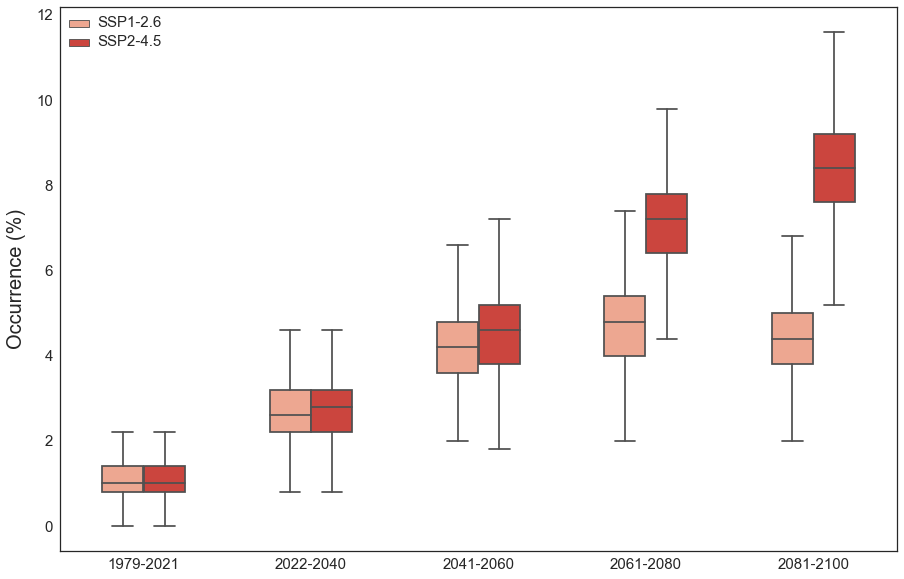

In [17]:
#boxplot PNW

c='white'

#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

fig1 = plt.figure(figsize=(15,10))
ax1 = fig1.add_subplot(1,1,1)
#ax2 = fig1.add_subplot(1,5,2)

#sns.pointplot(x=df_PNW_final["years"],y=df_PNW_final["Occurrence"],hue=df_PNW_final["Scenario"],ax=ax1,data=df_PNW_final, alpha=0.25, size=20, err_style='bars')
sns.boxplot(x=df_PNW_final["years"],y=df_PNW_final["Occurrence"],hue=df_PNW_final["Scenario"],ax=ax1,data=df_PNW_final, width = 0.5,palette="Reds",showfliers=False)
#ax1.set(ylim=(0,1))
#ax1.set(ylabel='Occurrence (%)', size =20)
ax1.set_xlabel('')
ax1.set_ylabel('Occurrence (%)',fontsize=20,labelpad=10)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)
#ax1.set_title('2015-2100', size=15, fontweight = 'light')
##ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])
#ax1.grid(False)
plt.legend(title='')
plt.setp(ax1.get_legend().get_title(), fontsize='15')
plt.setp(ax1.get_legend().get_texts(), fontsize='15')

plt.savefig('PNW_EP_995_boxplot.png',format ='png', dpi=150, bbox_inches='tight')

plt.show()

#shows this percentage of days will exceed this temperature within the time period 2081-2100

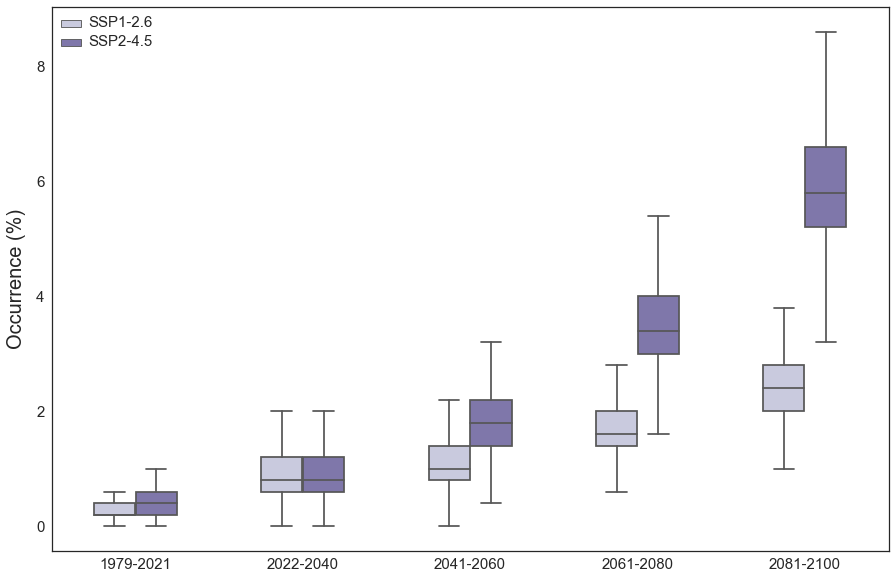

In [18]:
#boxplot SIB

c='white'

#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

fig1 = plt.figure(figsize=(15,10))
ax1 = fig1.add_subplot(1,1,1)
#ax2 = fig1.add_subplot(1,5,2)

#sns.pointplot(x=df_SIB_final["years"],y=df_SIB_final["Occurrence"],hue=df_SIB_final["Scenario"],ax=ax1,data=df_SIB_final, alpha=0.25, size=20, err_style='bars')
sns.boxplot(x=df_SIB_final["years"],y=df_SIB_final["Occurrence"],hue=df_SIB_final["Scenario"],ax=ax1,data=df_SIB_final, width = 0.5,palette="Purples",showfliers=False)
#ax1.set(ylim=(0,1))
#ax1.set(ylabel='Occurrence (%)', size =20)
ax1.set_xlabel('')
ax1.set_ylabel('Occurrence (%)',fontsize=20,labelpad=10)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)
#ax1.set_title('2015-2100', size=15, fontweight = 'light')
##ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])
#ax1.grid(False)
plt.legend(title='')
plt.setp(ax1.get_legend().get_title(), fontsize='15')
plt.setp(ax1.get_legend().get_texts(), fontsize='15')

plt.savefig('SIB_EP_995_boxplot.png',format ='png', dpi=150, bbox_inches='tight')

plt.show()

In [15]:
df_SIB245_future.to_excel('Spreadsheets/SIB245_corrected_delta.xlsx')
df_SIB126_future.to_excel('Spreadsheets/SIB126_corrected_delta.xlsx')
df_SIBE.to_excel('Spreadsheets/SIBE_corrected_delta.xlsx')

In [16]:
df_SIB_final.to_excel('Spreadsheets/SIB_EP_995.xlsx')
df_PNW_final.to_excel('Spreadsheets/PNW_EP_995.xlsx')